In [167]:
import os
import pandas as pd
import torch
from tqdm import tqdm
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
import datetime
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import seaborn as sns

In [170]:
model_params = {}
model_params["epochs"] = 10
model_params["lr"] = 0.001
model_params["data_size"] = 1
model_params["inp_size"] = 64
model_params["out_size"] = 32
model_params["batch_size"] = 32

cols_to_use = ["OPEN","HIGH","LOW","CLOSE","VOLUME","DELTA","ASK","BID"]

In [118]:
data_path = "../data/gbpusd"
files = list(os.walk(data_path))[0][2]
dfs = []
for file in files:
    if "_m15_" in file:
        _df = pd.read_csv(os.path.join(data_path,file),sep=";")
        _df["FILE"] = file
        dfs.append(_df)
df = pd.concat(dfs)
df.head()

,OPEN_DATE,OPEN_TIME,CLOSE_DATE,CLOSE_TIME,OPEN,HIGH,LOW,CLOSE,VOLUME,DELTA,ASK,BID,EXPIRATION,FILE,PRICE
0,02.01.2013,13:00,02.01.2013,13:15,1.6249,1.6300,1.6278,1.6297,3284,-142,1571,1713,03-13,6b_m15_20130101_20131231.csv,NaN
1,02.01.2013,13:15,02.01.2013,13:30,1.6297,1.6303,1.6282,1.6293,2070,86,1078,992,03-13,6b_m15_20130101_20131231.csv,NaN
2,02.01.2013,13:30,02.01.2013,13:45,1.6291,1.6314,1.6292,1.6297,2951,129,1540,1411,03-13,6b_m15_20130101_20131231.csv,NaN
3,02.01.2013,13:45,02.01.2013,14:00,1.6302,1.6302,1.6292,1.6292,1117,-77,520,597,03-13,6b_m15_20130101_20131231.csv,NaN
4,02.01.2013,14:00,02.01.2013,14:15,1.6292,1.6307,1.6290,1.6307,977,27,502,475,03-13,6b_m15_20130101_20131231.csv,NaN


In [119]:
df["OPEN_DATE"] = pd.to_datetime(df["OPEN_DATE"])
df = df.sort_values(by=["OPEN_DATE","OPEN_TIME"]).reset_index(drop=True)
df = df[~df["FILE"].str.contains('cluster')]
len(df)
df.head()

,OPEN_DATE,OPEN_TIME,CLOSE_DATE,CLOSE_TIME,OPEN,HIGH,LOW,CLOSE,VOLUME,DELTA,ASK,BID,EXPIRATION,FILE,PRICE
0,2012-01-02,01:00,01.02.2012,01:15,1.5764,1.5764,1.5757,1.5764,371,201,286,85,03-12,6b_m15_20120101_20121231.csv,NaN
1,2012-01-02,01:15,01.02.2012,01:30,1.5764,1.5760,1.5755,1.5764,119,-19,50,69,03-12,6b_m15_20120101_20121231.csv,NaN
2,2012-01-02,01:30,01.02.2012,01:45,1.5764,1.5760,1.5754,1.5764,188,48,118,70,03-12,6b_m15_20120101_20121231.csv,NaN
3,2012-01-02,01:45,01.02.2012,02:00,1.5764,1.5760,1.5749,1.5764,243,23,133,110,03-12,6b_m15_20120101_20121231.csv,NaN
4,2012-01-02,02:00,01.02.2012,02:15,1.5764,1.5754,1.5747,1.5764,251,-1,125,126,03-12,6b_m15_20120101_20121231.csv,NaN


In [120]:
x_scaler = StandardScaler()
x_scaler.fit(df[["OPEN","HIGH","LOW","CLOSE","VOLUME","DELTA","ASK","BID"]])
y_scaler = StandardScaler()
y_scaler.fit(df[["CLOSE"]])

StandardScaler()

In [121]:
def _create_data(df, input_len, output_len):
    inputs = list()
    outputs = list()
    for i in range(len(df)):
        X = df.iloc[i:i+input_len][cols_to_use]
        y = df.iloc[i+input_len:i+input_len+output_len][["CLOSE"]]
        if X.shape[0] == input_len and y.shape[0] == output_len:
            inputs.append(x_scaler.transform(X))
            change_in_time = y.iloc[-1] - y.iloc[0]
            outputs.append(change_in_time)
        else:
            continue

    return inputs, outputs

def create_data(file_names):

    X = []
    y = []
    
    for file_id in tqdm(file_names):
        _X, _y = _create_data(df[df["FILE"]==file_id],model_params["inp_size"],model_params["out_size"])
        X.extend(_X)
        y.extend(_y)
    
    return X,y

train_files = df["FILE"].unique()[:-1]
take_n_files = int(model_params["data_size"]*len(train_files))
train_files = train_files[:take_n_files]
test_files = df["FILE"].unique()[-1:]
X_train, y_train = create_data(train_files)
X_test, y_test = create_data(test_files)

100%|██████████| 1/1 [00:48<00:00, 48.08s/it]


In [124]:
class GBPDataset(Dataset):
    
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.y[idx])
    
    
train_dataset = GBPDataset(X_train,y_train)
train_loader = DataLoader(train_dataset, batch_size=model_params["batch_size"])

val_dataset = GBPDataset(X_test,y_test)
val_loader = DataLoader(val_dataset, batch_size=model_params["batch_size"])

next(iter(val_dataset))

(tensor([[-1.2606e+00, -1.2637e+00, -1.2672e+00, -1.2708e+00, -6.6952e-01,
           1.9868e-01, -6.4024e-01, -6.8827e-01],
         [-1.2708e+00, -1.2718e+00, -1.2699e+00, -1.2688e+00, -6.6609e-01,
           7.3128e-02, -6.5252e-01, -6.6921e-01],
         [-1.2694e+00, -1.2725e+00, -1.2726e+00, -1.2688e+00, -6.6815e-01,
           1.7684e-01, -6.4161e-01, -6.8419e-01],
         [-1.2687e+00, -1.2705e+00, -1.2767e+00, -1.2783e+00, -5.6720e-01,
           3.2423e-01, -5.2291e-01, -6.0252e-01],
         [-1.2796e+00, -1.2745e+00, -1.2760e+00, -1.2728e+00, -6.9218e-01,
           2.2597e-01, -6.5934e-01, -7.1413e-01],
         [-1.2715e+00, -1.2718e+00, -1.2685e+00, -1.2681e+00, -7.1965e-01,
          -1.4210e-02, -7.1664e-01, -7.1141e-01],
         [-1.2674e+00, -1.2691e+00, -1.2651e+00, -1.2681e+00, -7.1072e-01,
           3.4918e-02, -7.0163e-01, -7.0869e-01],
         [-1.2674e+00, -1.2705e+00, -1.2692e+00, -1.2728e+00, -6.8188e-01,
          -1.3976e-01, -6.9481e-01, -6.5833e-01],


In [140]:
class StasNet(nn.Module):
    
    def __init__(self):
        super(StasNet, self).__init__()
        self.lstm1 = nn.LSTM(8, 6)
        self.lstm2 = nn.LSTM(6,6)
        self.fc = nn.Linear(6,1)
                
    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = self.fc(x[:,-1,:])
        return x
    
out = StasNet().double()(next(iter(train_loader))[0])
out

tensor([[0.1073],
        [0.0758],
        [0.0635],
        [0.0593],
        [0.0610],
        [0.0596],
        [0.0598],
        [0.0557],
        [0.0577],
        [0.0624],
        [0.0664],
        [0.0709],
        [0.0740],
        [0.0768],
        [0.0773],
        [0.0792],
        [0.0807],
        [0.0789],
        [0.0792],
        [0.0798],
        [0.0800],
        [0.0790],
        [0.0789],
        [0.0784],
        [0.0794],
        [0.0793],
        [0.0799],
        [0.0814],
        [0.0816],
        [0.0832],
        [0.0829],
        [0.0835]], dtype=torch.float64, grad_fn=<AddmmBackward>)

In [141]:
tensorboard_log_dir = "../tensorboard"


timestamp = datetime.datetime.now().strftime("%y-%m-%d %H:%M:%S")
experiment_name = f'toy autoenocoder {timestamp}'
print(f"Experiment name: {experiment_name}")
writer = SummaryWriter(f'{tensorboard_log_dir}/{experiment_name}', flush_secs=1)
writer.add_hparams(model_params,{})

Experiment name: toy autoenocoder 21-01-03 00:20:01


In [142]:
#Instantiate the model
model = StasNet().double()
print(model)
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
print(f'Using {device}')
model.to(device)

#Loss function
criterion = nn.MSELoss()

#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=model_params["lr"])

#Epochs
n_epochs = model_params['epochs']

print(f"Training for {n_epochs} epochs")
for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0

    #Training
    with torch.enable_grad():
        for data in train_loader:
            inputs, predictions = data
            inputs = inputs.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, predictions)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*inputs.size(0)

        train_loss = train_loss/len(train_loader)
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))
    writer.add_scalar("Train loss", train_loss, epoch)

    with torch.no_grad():
    
        for data in val_loader:
            inputs, predictions = data
            inputs = inputs.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, predictions)
            train_loss += loss.item()*inputs.size(0)

        val_loss = train_loss/len(train_loader)
        print('Epoch: {} \tValidation Loss: {:.6f}'.format(epoch, val_loss))
    writer.add_scalar("Val loss", val_loss, epoch)


StasNet(
  (lstm1): LSTM(8, 6)
  (lstm2): LSTM(6, 6)
  (fc): Linear(in_features=6, out_features=1, bias=True)
)
Using cpu
Training for 10 epochs
Epoch: 1 	Training Loss: 0.017667
Epoch: 1 	Validation Loss: 0.001057
Epoch: 2 	Training Loss: 0.012383
Epoch: 2 	Validation Loss: 0.001107
Epoch: 3 	Training Loss: 0.012041
Epoch: 3 	Validation Loss: 0.001127
Epoch: 4 	Training Loss: 0.011879
Epoch: 4 	Validation Loss: 0.001096
Epoch: 5 	Training Loss: 0.011759
Epoch: 5 	Validation Loss: 0.001084
Epoch: 6 	Training Loss: 0.011671
Epoch: 6 	Validation Loss: 0.001057
Epoch: 7 	Training Loss: 0.011582
Epoch: 7 	Validation Loss: 0.001046
Epoch: 8 	Training Loss: 0.011498
Epoch: 8 	Validation Loss: 0.001039
Epoch: 9 	Training Loss: 0.011448
Epoch: 9 	Validation Loss: 0.001032
Epoch: 10 	Training Loss: 0.011406
Epoch: 10 	Validation Loss: 0.001031


In [188]:
val_loader_iter = iter(val_loader)

<AxesSubplot:label='dc980d74-aff0-4ac4-817a-f273e58fa851'>

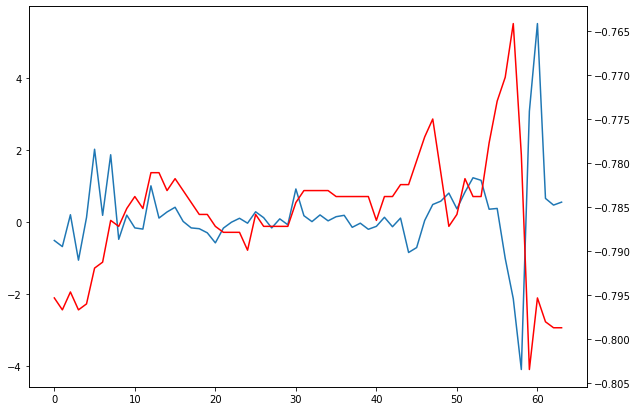

In [234]:
data = next(val_loader_iter)
inputs, predictions = data
inputs = inputs.to(device)
outputs = model(inputs)

plt.figure(figsize=(10,7))
e_input = pd.DataFrame(inputs[0].detach().numpy(),columns=cols_to_use)
e_input["DELTA"].plot()
ax1 = plt.gca()
ax2 = ax1.twinx()
e_input["CLOSE"].plot(color="red")

In [157]:
outputs[0]

tensor([0.0072], dtype=torch.float64, grad_fn=<SelectBackward>)

In [158]:
predictions[0]

tensor([0.0133], dtype=torch.float64)